# Introdução
Após a análise exploratória feita no outro arquivo, será feito o Machine Learning com os dados e conclusões obtidas.

# 1. Carregamento de Dataset
Utilizaremos os mesmos métodos de carregamento do arquivo de análise exploratória

## a) Utilizar a API do Kaggle

In [ ]:
# Parte para baixar o arquivo utilizando a API do Kaggle
import kagglehub

# Baixando o arquivo
caminho = kagglehub.dataset_download("khushikyad001/electric-vehicle-analytics-dataset")

print("Caminho para o dataset:", caminho)

## b) Utilizar arquivo .csv já baixado

In [1]:
# Parte para utilizar o arquivo já baixado
import os

# Começando o caminho vazio
caminho = None

# Procurando o arquivo no diretório atual
arquivos = os.listdir(".")
for arquivo in arquivos:
    if arquivo == "electric_vehicle_analytics.csv":
        caminho = os.path.join(".",arquivo)
        break

if caminho:
    print("Caminho para o dataset:", caminho)
else:
    print("Dataset não encontrado!")

Caminho para o dataset: .\electric_vehicle_analytics.csv


# 2. Pré-tratamento de dados
Nesta parte será retirada a coluna de ID de veículos, por não ser útil para a IA e também as variáveis categóricas serão tratadas para que possam ser utilizadas pela IA. Por último os dados serão separados entre teste e treino.

In [3]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Carregando o Dataset
df = pd.read_csv(caminho)

# Definindo a coluna de saída
TARGET_COL = "Resale_Value_USD"

# Retirando a coluna de ID
df = df.drop(columns="Vehicle_ID")

# Tratando o Ano do carro como a sua "idade"
ano_atual = datetime.now().year
df["Idade"] = ano_atual - df["Year"]
df = df.drop("Year", axis= 1)

# Tratando as variáveis categóricas
le_Make = LabelEncoder()
le_Model = LabelEncoder()
le_Region = LabelEncoder()
le_Vehicle_Type = LabelEncoder()
le_Usage_Type = LabelEncoder()

# Codificando as variáveis categóricas
df["Make"] = le_Make.fit_transform(df["Make"])
df["Model"] = le_Model.fit_transform(df["Model"])
df["Region"] = le_Region.fit_transform(df["Region"])
df["Vehicle_Type"] = le_Vehicle_Type.fit_transform(df["Vehicle_Type"])
df["Usage_Type"] = le_Usage_Type.fit_transform(df["Usage_Type"])

# Separando as entradas e saída
X = df.drop(columns=TARGET_COL)
y = df[TARGET_COL]

# Separado os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 3. Criação da IA
Nesta parte serão criados 3 modelos diferentes de ensemble para no final o desempenho de cada um ser comparado e decidir qual é o melhor.

In [9]:
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Aleatorizando parâmetros para o RandomizedSearch
gb_param = {
    "learning_rate" : np.arange(0.01,1.0,0.01),
    "n_estimators": randint(3,41),
    "subsample": np.arange(0.01, 1.0, 0.05)
}

rf_param = {
    "max_depth": randint(1,11),
    "n_estimators": randint(3,41)
}

bg_param = {
    "n_estimators": randint(3,41),
    "max_samples": np.arange(0.01, 1.0, 0.05)
}

# Selecionando os modelos
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()
bg = BaggingRegressor()

# Fazendo a RandomizedSearch
gb_search = RandomizedSearchCV(gb, gb_param, n_iter=20, scoring="neg_root_mean_squared_error", cv=3, random_state=100, verbose=2)
rf_search = RandomizedSearchCV(rf, rf_param, n_iter=20, scoring="neg_root_mean_squared_error", cv=3, random_state=100, verbose=2)
bg_search = RandomizedSearchCV(bg, bg_param, n_iter=20, scoring="neg_root_mean_squared_error", cv=3, random_state=100, verbose=2)

# Treinando as IAs
gb_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)
bg_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.09, n_estimators=27, subsample=0.16000000000000003; total time=   0.0s
[CV] END learning_rate=0.09, n_estimators=27, subsample=0.16000000000000003; total time=   0.0s
[CV] END learning_rate=0.09, n_estimators=27, subsample=0.16000000000000003; total time=   0.0s
[CV] END learning_rate=0.88, n_estimators=18, subsample=0.81; total time=   0.0s
[CV] END learning_rate=0.88, n_estimators=18, subsample=0.81; total time=   0.0s
[CV] END learning_rate=0.88, n_estimators=18, subsample=0.81; total time=   0.0s
[CV] END learning_rate=0.11, n_estimators=33, subsample=0.11; total time=   0.0s
[CV] END learning_rate=0.11, n_estimators=33, subsample=0.11; total time=   0.0s
[CV] END learning_rate=0.11, n_estimators=33, subsample=0.11; total time=   0.0s
[CV] END .learning_rate=0.54, n_estimators=5, subsample=0.11; total time=   0.0s
[CV] END .learning_rate=0.54, n_estimators=5, subsample=0.11; total time=   0.0s
[CV

,estimator,BaggingRegressor()
,param_distributions,"{'max_samples': array([0.01, ..., 0.91, 0.96]), 'n_estimators': <scipy.stats....001BD724C6E50>}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,100
,error_score,nan


In [10]:
# Mostrando as pontuações
print("----------//----------")
print(f"Melhor Gradient Boosting: {gb_search.best_estimator_}")
print(f"Pontuação: {gb_search.best_score_}")
print("----------//----------")
print(f"Melhor Random Forest: {rf_search.best_estimator_}")
print(f"Pontuação: {rf_search.best_score_}")
print("----------//----------")
print(f"Melhor Bagging: {bg_search.best_estimator_}")
print(f"Pontuação: {bg_search.best_score_}")

----------//----------
Melhor Gradient Boosting: GradientBoostingRegressor(learning_rate=np.float64(0.15000000000000002),
                          n_estimators=37,
                          subsample=np.float64(0.8600000000000001))
Pontuação: -1829.2982546258
----------//----------
Melhor Random Forest: RandomForestRegressor(max_depth=5, n_estimators=37)
Pontuação: -1854.5509015538871
----------//----------
Melhor Bagging: BaggingRegressor(max_samples=np.float64(0.46), n_estimators=33)
Pontuação: -1865.8959384477275


# 4. Teste das IAs
Nesta parte será feito os testes para as IAs e depois a comparação entre elas.

In [11]:
from sklearn.metrics import mean_squared_error

# Melhores modelos
melhor_gb = gb_search.best_estimator_
melhor_rf = rf_search.best_estimator_
melhor_bg = bg_search.best_estimator_

# Fazendo a predição
gb_predict = melhor_gb.predict(X_test)
rf_predict = melhor_rf.predict(X_test)
bg_predict = melhor_bg.predict(X_test)

predicoes = [gb_predict, rf_predict, bg_predict]

# Testando os modelos
gb_erro = np.sqrt(mean_squared_error(y_test, gb_predict))
rf_erro = np.sqrt(mean_squared_error(y_test, rf_predict))
bg_erro = np.sqrt(mean_squared_error(y_test, bg_predict))

print("----------//----------")
print("Modelo: Gradient Boosting")
print("RMSE: ", gb_erro)
print("----------//----------")
print("Modelo: Random Forest")
print("RMSE: ", rf_erro)
print("----------//----------")
print("Modelo: Bagging")
print("RMSE: ", bg_erro)

----------//----------
Modelo: Gradient Boosting
RMSE:  1850.7520662733702
----------//----------
Modelo: Random Forest
RMSE:  1892.1926948471285
----------//----------
Modelo: Bagging
RMSE:  1878.5299288147392


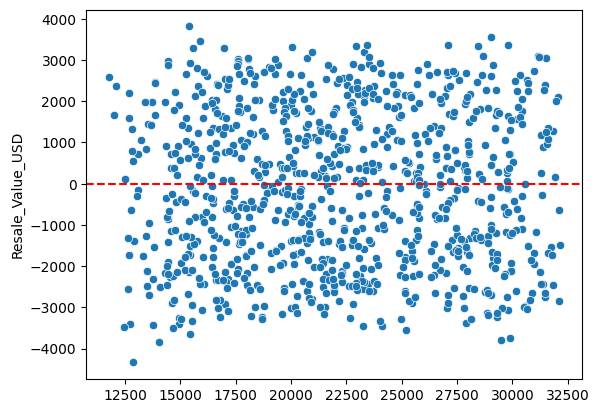

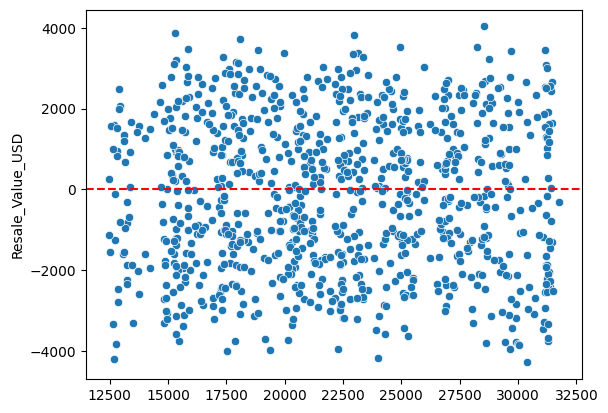

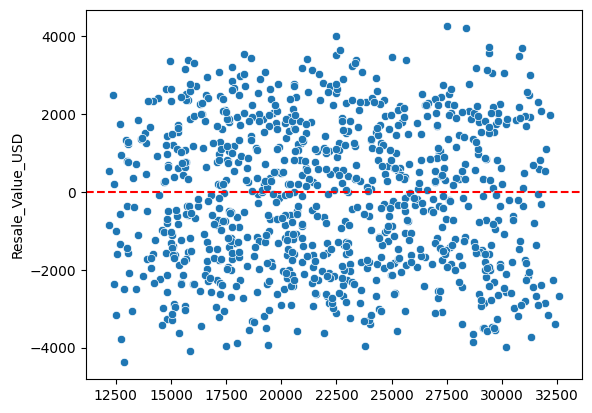

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

for predicao in predicoes:
    residuos = y_test - predicao
    sns.scatterplot(x= predicao, y= residuos)
    plt.axhline(0, color="red", linestyle="--")
    plt.show()